In [1]:
import Pkg

#Pkg.add("Zygote")

using Zygote
using Flux
using Flux: onehotbatch, onecold, crossentropy
using MLDatasets
#using CUDA
using Statistics
using Plots

In [2]:
train_x, train_y = CIFAR100(:train).features, CIFAR100(:train).targets
test_x, test_y = CIFAR100(:test).features, CIFAR100(:test).targets

train_x = permutedims(Float32.(train_x) ./ 255.0, (1,2,3,4))  
test_x = permutedims(Float32.(test_x) ./ 255.0, (1,2,3,4)) 

train_y = CIFAR100(:train).targets.fine
test_y = CIFAR100(:test).targets.fine

train_y = onehotbatch(vec(train_y), 0:99)  
test_y = onehotbatch(vec(test_y), 0:99)

;

In [3]:
class_names = [
    "apple", "aquarium_fish", "baby", "bear", "beaver", "bed", "bee", "beetle", "bicycle", "bottle",
    "bowl", "boy", "bridge", "bus", "butterfly", "camel", "can", "castle", "caterpillar", "cattle",
    "chair", "chimpanzee", "clock", "cloud", "cockroach", "couch", "crab", "crocodile", "cup", "dinosaur",
    "dolphin", "elephant", "flatfish", "forest", "fox", "girl", "hamster", "house", "kangaroo", "keyboard",
    "lamp", "lawn_mower", "leopard", "lion", "lizard", "lobster", "man", "maple_tree", "motorcycle", "mountain",
    "mouse", "mushroom", "oak_tree", "orange", "orchid", "otter", "palm_tree", "pear", "pickup_truck", "pine_tree",
    "plain", "plate", "poppy", "porcupine", "possum", "rabbit", "raccoon", "ray", "road", "rocket",
    "rose", "sea", "seal", "shark", "shrew", "skunk", "skyscraper", "snail", "snake", "spider",
    "squirrel", "streetcar", "sunflower", "sweet_pepper", "table", "tank", "telephone", "television", "tiger", "tractor",
    "train", "trout", "tulip", "turtle", "wardrobe", "whale", "willow_tree", "wolf", "woman", "worm"
];

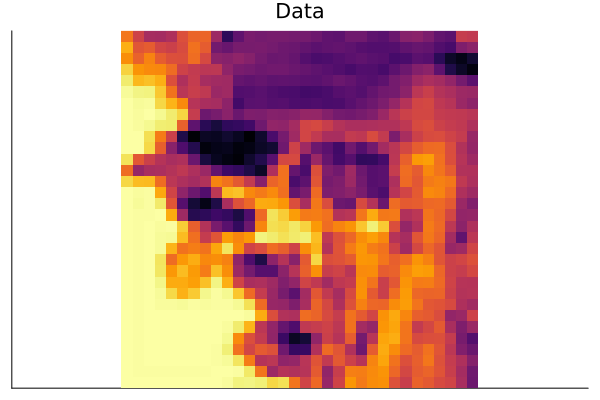

In [4]:
input_data = train_x[:, :, :, 1:1]

input_plot = heatmap(input_data[:, :, 1, 1], axis=nothing, title="Data", xticks=false, yticks=false, colorbar=false, aspect_ratio=:equal) 


In [5]:
conv1 = Conv((3,3), 3=>16, relu)
pool1 = MaxPool((2,2))
conv2 = Conv((3,3), 16=>32, relu)
pool2 = MaxPool((2,2))
conv3 = Conv((3,3), 32=>64, relu)
pool3 = MaxPool((2,2))
flatten = Flux.flatten
dense1 = Dense(256, 128, relu)
dense2 = Dense(128, 100)


model = Chain(conv1, pool1, BatchNorm(16), conv2, pool2, BatchNorm(32), conv3, pool3, BatchNorm(64), flatten, dense1, dense2, softmax)

loss(m, x, y) = crossentropy(m(x), y)

opt = ADAM();

In [6]:
function train_model!(model, train_X, train_Y, opt, epochs, batch_size)
    data_loader = Flux.DataLoader((train_X, train_Y), batchsize=batch_size, shuffle=true)
    
    opt_state = Flux.setup(opt, model)  
    total_loss = []

    for epoch in 1:epochs
        epoch_loss = 0
        for (x, y) in data_loader
            gs = Flux.gradient(model -> Flux.Losses.crossentropy(model(x), y), model)[1]  
            Flux.update!(opt_state, Flux.trainable(model), gs)
            epoch_loss += Flux.Losses.crossentropy(model(x), y)
        end
        println("Epoch $epoch complete")
        push!(total_loss, epoch_loss)
    end
    return total_loss
end

train_model! (generic function with 1 method)

In [7]:
epochs = 100
batch_size = 64;

In [8]:
loss_list = train_model!(model, train_x, train_y, opt, epochs, batch_size);

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Conv((3, 3), 3 => 16, relu)  # 448 parameters
│   summary(x) = "32×32×3×64 Array{Float64, 4}"
└ @ Flux ~/.julia/packages/Flux/3711C/src/layers/stateless.jl:60


Epoch 1 complete
Epoch 2 complete
Epoch 3 complete
Epoch 4 complete
Epoch 5 complete
Epoch 6 complete
Epoch 7 complete
Epoch 8 complete
Epoch 9 complete
Epoch 10 complete
Epoch 11 complete
Epoch 12 complete
Epoch 13 complete
Epoch 14 complete
Epoch 15 complete
Epoch 16 complete
Epoch 17 complete
Epoch 18 complete
Epoch 19 complete
Epoch 20 complete
Epoch 21 complete
Epoch 22 complete
Epoch 23 complete
Epoch 24 complete
Epoch 25 complete
Epoch 26 complete
Epoch 27 complete
Epoch 28 complete
Epoch 29 complete
Epoch 30 complete
Epoch 31 complete
Epoch 32 complete
Epoch 33 complete
Epoch 34 complete
Epoch 35 complete
Epoch 36 complete
Epoch 37 complete
Epoch 38 complete
Epoch 39 complete
Epoch 40 complete
Epoch 41 complete
Epoch 42 complete
Epoch 43 complete
Epoch 44 complete
Epoch 45 complete
Epoch 46 complete
Epoch 47 complete
Epoch 48 complete
Epoch 49 complete
Epoch 50 complete
Epoch 51 complete
Epoch 52 complete
Epoch 53 complete
Epoch 54 complete
Epoch 55 complete
Epoch 56 complete
E

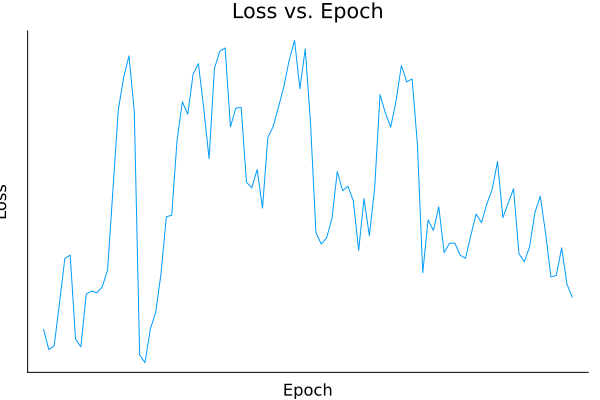

In [9]:
p1 = plot(1:epochs, loss_list, xlabel="Epoch", ylabel="Loss", title="Loss vs. Epoch", legend=false, xticks=false, yticks=false)
display(p1)

In [10]:
#visualize_layers(model, train_x[:, :, :, 1:1])

accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))
println("Test Accuracy: ", accuracy(test_x, test_y))


Test Accuracy: 0.1738


In [11]:
function visualize_layer(input_data, layer, filter_labels)
    output = layer(input_data)  # Apply the convolutional layer

    num_filters = size(output, 4)  # Number of output channels

    # Create input plot
    input_plot = heatmap(input_data[:, :, 1, 1], axis=nothing, title=label, xticks=false, yticks=false, colorbar=false,
    #color =:acton, 
    aspect_ratio=:equal
    )

    # Create output plots for each filter response with labels
    output_plots = [
        heatmap(output[:, :, 1, i], axis=nothing, 
                title=filter_labels,
                xticks=false, yticks=false, colorbar=false,
                #color =:acton
                ) 
        for i in 1:num_filters
    ]

    # Arrange plots in a grid (side by side)
    plot(input_plot, output_plots..., layout=(1, num_filters + 1))
end

using Flux

# Define each filter as a 3x3 matrix

# Laplacian
f1 = [ 0  -1  0; -1  4 -1;  0  -1  0 ]

# Sharpening
f2 = [ 0  -1  0; -1  9 -1;  0  -1  0 ]

# Sobels
f3 = [ 1   2  1;  0  0  0; -1  -2 -1 ]
f4 = [ 1   0 -1;  2  0 -2;  1   0 -1 ]

# Gaussian Blur
f5 = (1/16).*[ 1   2  1;  2  4  2;  1   2  1 ]
f7 = (1/273).*[ 1 4 7 4 1; 4 16 26 16 4; 7 26 41 26 7; 4 16 26 16 4; 1 4 7 4 1 ] 
f8 = (1/1003) .* [ 0 0 1 2 1 0 0; 0 3 13 22 13 3 0; 1 13 59 97 59 13 1; 2 22 97 159 97 22 2; 1 13 59 97 59 13 1; 0 3 13 22 13 3 0; 0 0 1 2 1 0 0 ]

# Embossing
f6 = [-2  -1  0; -1  1  1;  0   1  2 ]

# Box Blur
f9 = (1/9) .* [ 1 1 1; 1 1 1; 1 1 1 ]


f10 = (-1/256).*[ 1 4 6 4 1; 4 16 24 16 4; 6 24 -476 24 6; 4 16 24 16 4; 1 4 6 4 1 ]

# some custom filter
f11 = [ 4 0 1 0 1; 0 0 0 0 0; 1 0 10 0 1; 0 0 0 0 0; 1 0 1 0 1]

# Inverse Gaussian Blur
f12 = (1/14).*[ 20 5 20; 5 0 5; 20 5 20]

# Alternative Sobels
f13 = [ 3 0 -3; 10 0 -10; 3 0 -3]
f14 = [ 3 10 3; 0 0 0; -3 -10 -3]

# Scharr Operator
f15 = [47 0 -47; 162 0 -162; 47 0 -47]
f17 = [47 162 47; 0 0 0; -47 -162 -47]

# Reshape each filter to include the input channel and output channel dimensions (3, 3, 1, 1)
f1_tensor = reshape(f1, (3, 3, 1, 1))
f2_tensor = reshape(f2, (3, 3, 1, 1))
f3_tensor = reshape(f3, (3, 3, 1, 1))
f4_tensor = reshape(f4, (3, 3, 1, 1))
f5_tensor = reshape(f5, (3, 3, 1, 1))
f6_tensor = reshape(f6, (3, 3, 1, 1))
f7_tensor = reshape(f7, (5, 5, 1, 1))
f8_tensor = reshape(f8, (7, 7, 1, 1))
f9_tensor = reshape(f9, (3, 3, 1, 1))
f10_tensor = reshape(f10, (5, 5, 1, 1))
f11_tensor = reshape(f11, (5, 5, 1, 1))
f12_tensor = reshape(f12, (3, 3, 1, 1))
f13_tensor = reshape(f13, (3, 3, 1, 1))
f14_tensor = reshape(f14, (3, 3, 1, 1))
f15_tensor = reshape(f15, (3, 3, 1, 1))
f17_tensor = reshape(f17, (3, 3, 1, 1))



# Define filter labels corresponding to their function
filter_labels = [
    "Laplacian (Edge Detection)", 
    "Sharpening", 
    "Sobel (Vertical Edges)", 
    "Sobel (Horizontal Edges)", 
    "Gaussian Blur",
    "Embossing",
    "Large Gaussian Blur",
    "Super Large Gaussian Blur",
    "Box Blur",
    "Unsharp Masking",
    "Every Other",
    "Inverse Gaussian Blur",
    "Alternative Sobel (Vertical Edges)",
    "Alternative Sobel (Horizontal Edges)",
    "Scharr Operator (Vertical Edges)",
    "Empty",
    "Scharr Operator (Horizontal Edges)"
];

n = length(filter_labels)

;

In [12]:
pad_set = 0
stride_set = 1
choice = 137
;

In [13]:
label = class_names[argmax(train_y[:, choice]) - 1]

"rabbit"

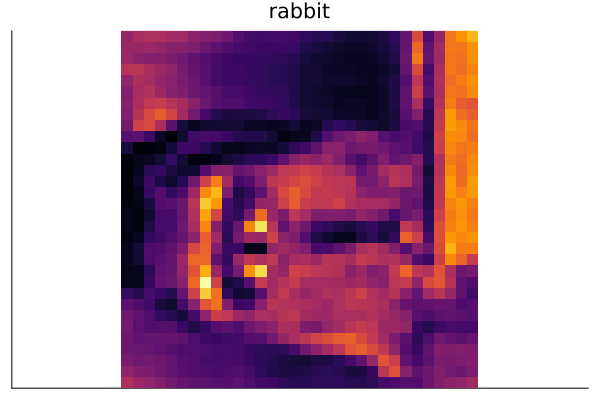

In [14]:
input_data = train_x[:, :, :, choice:choice]

input_plot = heatmap(input_data[:, :, 1, 1], 
                     axis=nothing, 
                     title=label, 
                     xticks=false, 
                     yticks=false, 
                     colorbar=false, 
                     aspect_ratio=:equal,
                     #color =:acton
                     ) 



In [15]:
conv_layer_1 = Conv((3, 3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_1.weight .=f1_tensor

conv_layer_2 = Conv((3, 3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_2.weight .=f2_tensor

conv_layer_3 = Conv((3, 3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_3.weight .=f3_tensor

conv_layer_4 = Conv((3, 3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_4.weight .=f4_tensor

conv_layer_5 = Conv((3, 3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_5.weight .=f5_tensor

conv_layer_6 = Conv((3, 3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_6.weight .=f6_tensor;

conv_layer_7 = Conv((5,5), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_7.weight .=f7_tensor;

conv_layer_8 = Conv((7,7), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_8.weight .=f8_tensor;

conv_layer_9 = Conv((3,3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_9.weight .=f9_tensor;

conv_layer_10 = Conv((5,5), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_10.weight .=f10_tensor;

conv_layer_11 = Conv((5,5), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_11.weight .=f11_tensor;

conv_layer_12 = Conv((3,3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_12.weight .=f12_tensor;

conv_layer_13 = Conv((3,3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_13.weight .=f13_tensor;

conv_layer_14 = Conv((3,3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_14.weight .=f14_tensor;

conv_layer_15 = Conv((3,3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_15.weight .=f15_tensor;

conv_layer_17 = Conv((3,3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_17.weight .=f17_tensor;



;

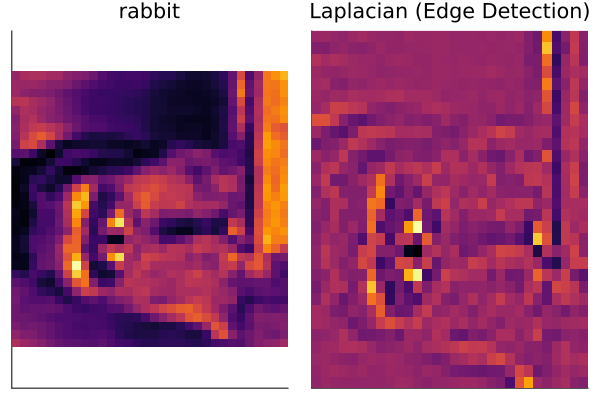

In [16]:
visualize_layer(input_data, conv_layer_1, filter_labels[1])

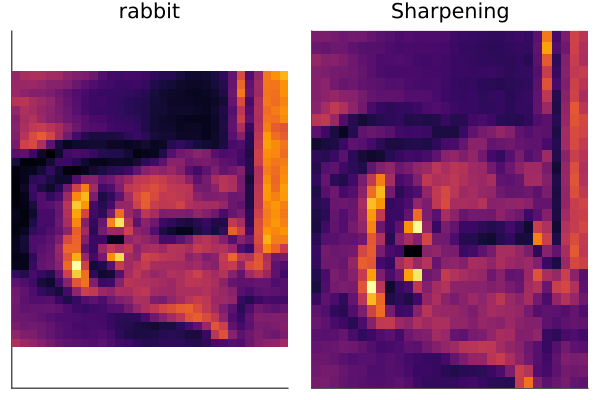

In [17]:
visualize_layer(input_data, conv_layer_2, filter_labels[2])

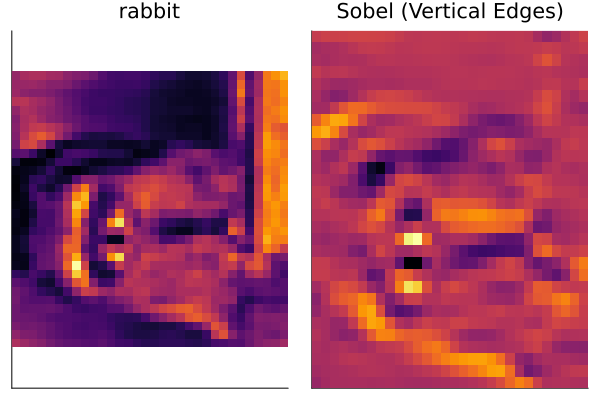

In [18]:
visualize_layer(input_data, conv_layer_3, filter_labels[3])

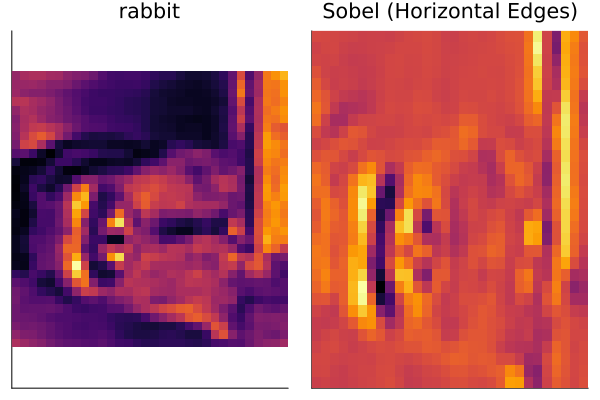

In [19]:
visualize_layer(input_data, conv_layer_4, filter_labels[4])

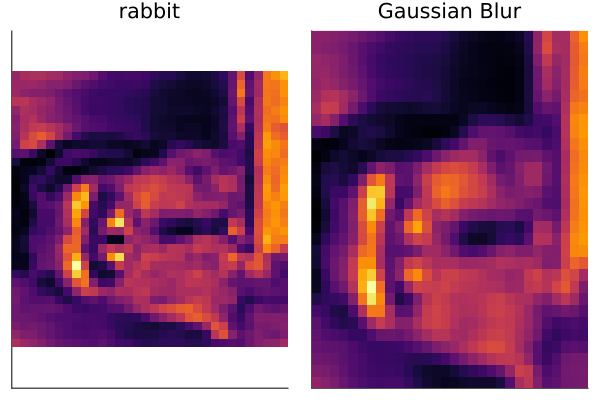

In [20]:
visualize_layer(input_data, conv_layer_5, filter_labels[5])

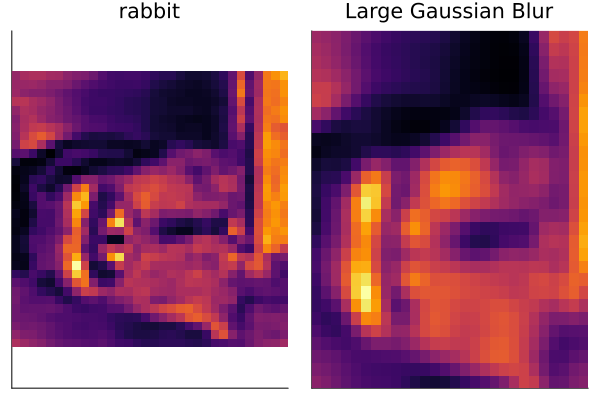

In [21]:
visualize_layer(input_data, conv_layer_7, filter_labels[7])

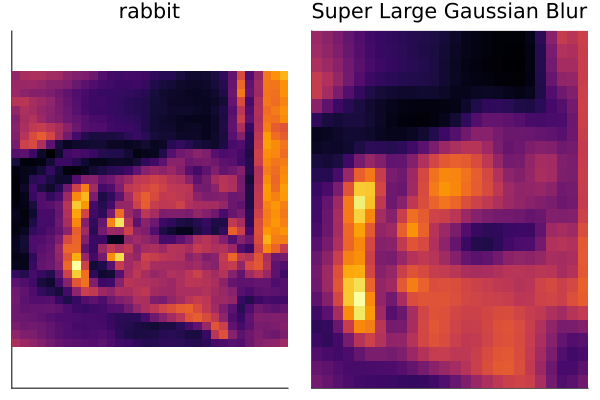

In [22]:
visualize_layer(input_data, conv_layer_8, filter_labels[8])

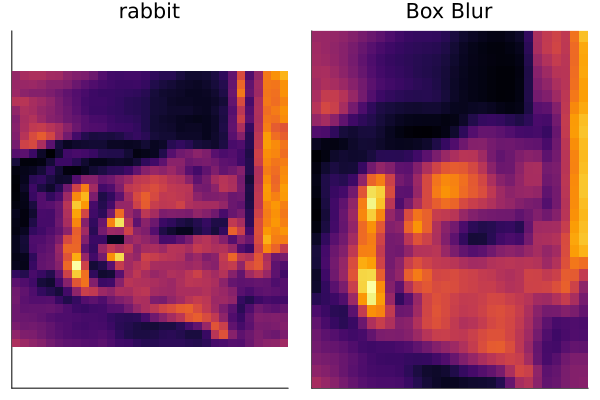

In [23]:
visualize_layer(input_data, conv_layer_9, filter_labels[9])

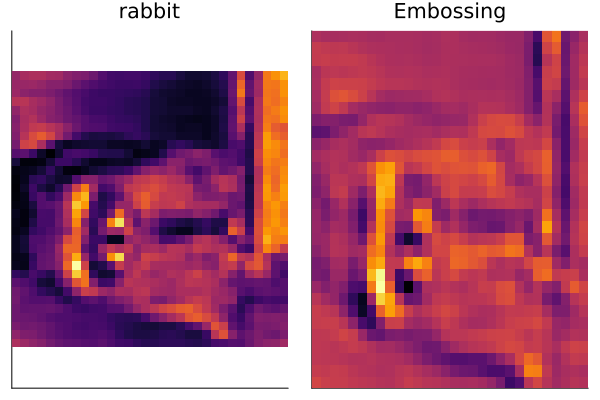

In [24]:
visualize_layer(input_data, conv_layer_6, filter_labels[6])

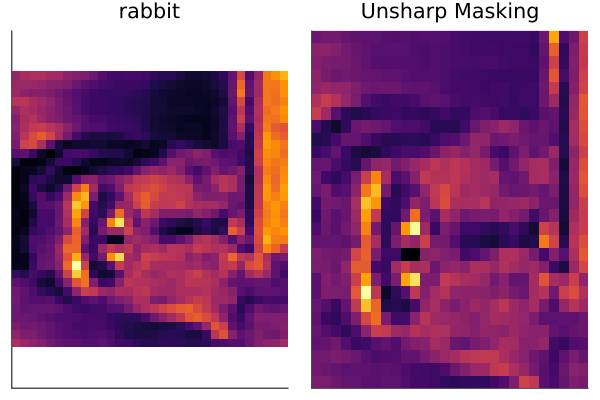

In [25]:
visualize_layer(input_data, conv_layer_10, filter_labels[10])

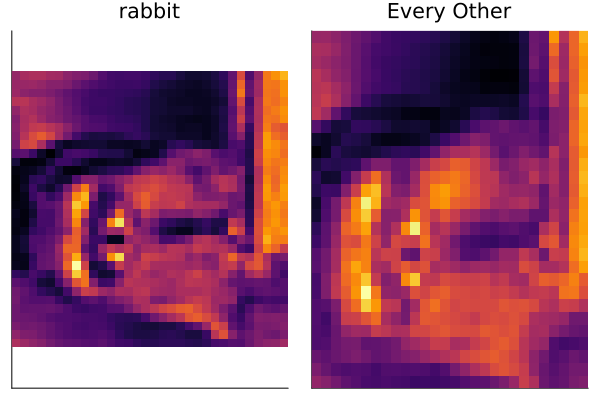

In [26]:
visualize_layer(input_data, conv_layer_11, filter_labels[11])

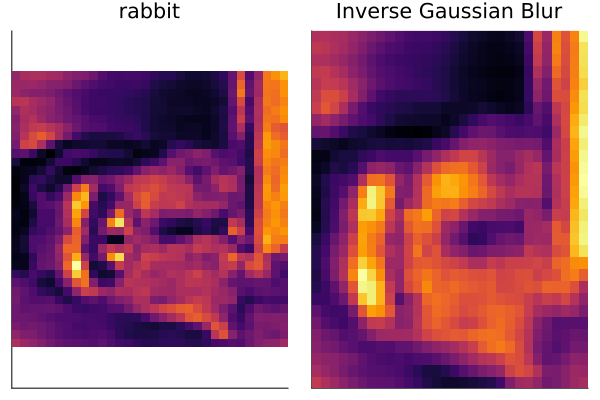

In [27]:
visualize_layer(input_data, conv_layer_12, filter_labels[12])

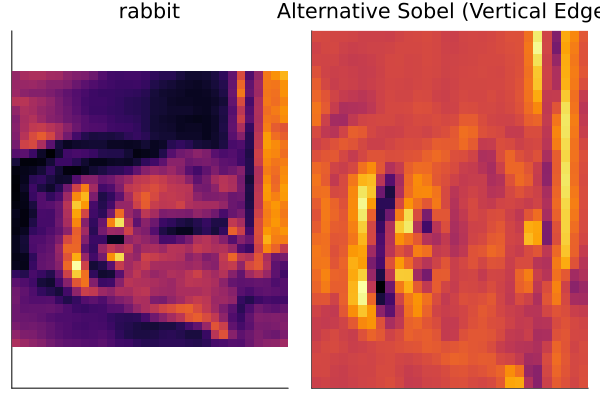

In [28]:
visualize_layer(input_data, conv_layer_13, filter_labels[13])

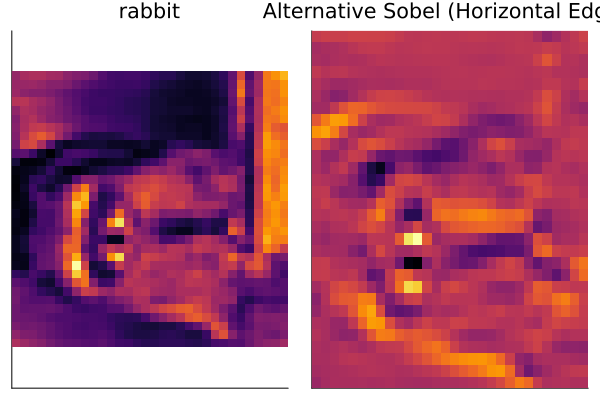

In [29]:
visualize_layer(input_data, conv_layer_14, filter_labels[14])

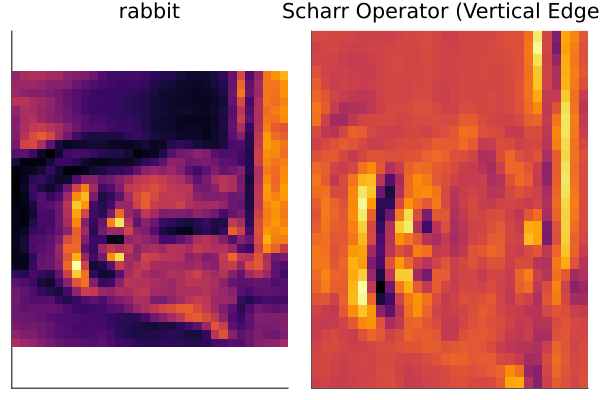

In [30]:
visualize_layer(input_data, conv_layer_15, filter_labels[15])

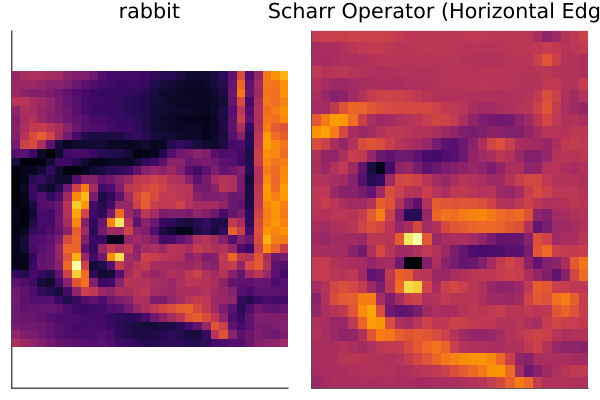

In [31]:
visualize_layer(input_data, conv_layer_17, filter_labels[17])